In [595]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , ModelCheckpoint
from keras.models import load_model
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

import tensorflow as tf
print(tf.__version__)

1.15.0


In [596]:
epochs=2000
batch_size=300

learning_rate = 1e-3
decay = learning_rate / epochs

patience=80

test_split = 0.1
validation_split = 0.1

select_features=True

SCALE_TARGET = True
SCALE_FEATURES = True

RUN_MODEL = True


In [597]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'
models_dir = home_dir + "/models/"

data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


In [598]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [599]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,...,user-db_net_use,shipping_net_use,payment_net_use,carts_net_use,carts-db_net_use,nodes_cpu_use,nodes_disk_io,nodes_net_use,orders_req,orders_ltcy
0,0.0300,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0300,0.0700,1.0000,...,2.2044,2.6585,8.9654,22.0117,4.7995,2.5000,1.6700,2.7617,0.1500,0.2400
1,0.0600,0.0200,0.0200,0.0200,0.0200,0.0100,0.0100,0.1800,0.1800,1.0000,...,2.2044,2.6585,8.9654,22.0117,4.7995,1.8900,1.0100,2.7617,0.1500,0.2400
2,0.0700,0.0300,0.0200,0.0300,0.0200,0.0100,0.0100,0.4400,0.2000,1.0000,...,16.0739,13.5708,16.9964,27.3438,16.6522,1.3500,0.0500,2.5880,0.1500,0.2400
3,0.0700,0.0300,0.0200,0.0200,0.0200,0.0100,0.0100,0.2300,0.1700,1.0000,...,19.9869,14.4342,9.5804,9.4313,17.1768,1.2600,0.0400,2.1487,0.1300,0.2400
4,0.0700,0.0200,0.0100,0.0200,0.0200,0.0100,0.0100,0.2400,0.1400,1.0000,...,10.4490,3.7392,2.7970,9.1791,6.2516,1.2800,0.2600,1.8080,0.3600,0.2400


In [600]:
data.shape

(6766, 29)

# clear noice from outliers

In [601]:
df = data

In [602]:
df.describe(include="all")

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,...,user-db_net_use,shipping_net_use,payment_net_use,carts_net_use,carts-db_net_use,nodes_cpu_use,nodes_disk_io,nodes_net_use,orders_req,orders_ltcy
count,"6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000",...,"6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000","6,766.0000"
mean,0.8273,0.2116,0.0202,0.1991,0.1194,0.0523,0.0318,0.5306,1.8280,2.7575,...,80.5966,20.0340,19.0734,81.9750,50.6044,4.1043,0.3546,11.5734,5.0330,2.9729
std,0.6170,0.1319,0.0049,0.1350,0.0804,0.0443,0.0122,0.5758,1.9903,1.0979,...,62.8980,11.9240,11.1184,74.1385,50.1669,2.0826,0.5834,6.8714,4.2009,3.5143
min,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0300,0.0100,0.5000,...,2.2044,0.8558,1.9247,1.1096,1.0867,1.1000,0.0000,1.5182,0.0000,0.0200
25%,0.1900,0.0800,0.0200,0.0500,0.0300,0.0400,0.0200,0.1200,0.0200,2.0000,...,16.2957,13.2383,13.4314,20.5533,8.3766,1.9200,0.0100,3.2508,0.4900,0.2400
50%,0.8400,0.2200,0.0200,0.2000,0.1200,0.0500,0.0300,0.3200,1.1550,3.0000,...,76.6752,16.1914,14.7847,59.9569,34.1490,4.2100,0.0300,12.2534,5.1450,0.4900
75%,1.2900,0.3000,0.0200,0.3000,0.1800,0.0600,0.0400,0.5800,3.2800,4.0000,...,126.2338,24.8655,22.1350,131.5723,82.3012,5.7800,0.4200,17.2900,8.1950,5.8090
max,2.7300,0.9100,0.0400,0.6400,0.3400,0.6300,0.1000,2.5300,6.5800,4.0000,...,302.1511,92.7541,86.7911,454.9671,383.2832,9.6600,2.9600,27.2761,20.1300,9.7500


In [603]:
df = data
print('shape before {}'.format(df.shape))
if 1 == 0:
    minq = df['orders_ltcy'].quantile(0.3)
    maxq = df['orders_ltcy'].quantile(0.99)
    print('latency quantiles min {} max {}'.format(maxq, minq))
    df = df[df['orders_ltcy'] > minq]
    df = df[df['orders_ltcy'] < maxq]
    sns.distplot(df['orders_ltcy'])
print('shape after {}'.format(df.shape)) 

shape before (6766, 29)
shape after (6766, 29)


In [604]:
data = df
data.shape

(6766, 29)

# Shuffle the data

In [605]:
# shuffle the data
from sklearn.utils import shuffle
data = shuffle(data, random_state=365)
print('shape {}'.format(data.shape))
data.head(5)

shape (6766, 29)


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,...,user-db_net_use,shipping_net_use,payment_net_use,carts_net_use,carts-db_net_use,nodes_cpu_use,nodes_disk_io,nodes_net_use,orders_req,orders_ltcy
4064,1.6700,0.3600,0.0200,0.4000,0.2100,0.0300,0.0300,1.6400,0.5400,3.0000,...,201.9787,29.0615,33.6533,73.3149,24.3671,4.9200,0.0100,22.5661,7.7100,9.3600
614,0.6200,0.4100,0.0300,0.3200,0.1900,0.0700,0.0200,0.4300,4.2600,1.0000,...,169.4398,29.0119,24.0921,172.9419,130.5992,6.9400,1.8300,19.3568,7.5100,0.7800
3015,1.5600,0.4100,0.0100,0.4400,0.2500,0.0200,0.0200,1.0800,0.0100,2.0000,...,256.4720,6.7118,6.7848,5.3775,2.5734,4.0700,0.0300,23.0483,6.4900,3.8500
5901,0.4600,0.1300,0.0200,0.1200,0.0600,0.0600,0.0400,0.1600,1.2400,4.0000,...,56.6062,33.1268,60.1165,63.8153,44.9579,2.6100,0.0200,7.4801,2.7800,0.2300
6323,1.6200,0.3800,0.0300,0.3500,0.2200,0.1000,0.0600,0.5000,5.2400,4.0000,...,164.3058,78.8242,44.1672,268.2326,170.2118,6.6500,0.0900,18.8154,11.6000,2.8900


In [606]:
x_data = data.drop(['orders_ltcy'], axis=1)
x_data = x_data.values
print("Shape x_data: ", x_data.shape)
print("type x_data: ", type(x_data))

y_data = data['orders_ltcy'].values
y_data = y_data.reshape(-1,1)

print("Shape y_data: ", y_data.shape)
print("type y_data: ", type(y_data))

num_data = len(x_data)
print("There are {} sample data".format(num_data))

Shape x_data:  (6766, 28)
type x_data:  <class 'numpy.ndarray'>
Shape y_data:  (6766, 1)
type y_data:  <class 'numpy.ndarray'>
There are 6766 sample data


# Scale Target

In [607]:
if SCALE_TARGET:
    y_scaler =  MinMaxScaler() # StandardScaler() or MinMaxScaler()
    y_data = y_scaler.fit_transform(y_data)

In [608]:
pd.DataFrame(y_data).describe(include="all")

,0
count,"6,766.0000"
mean,0.3035
std,0.3612
min,0.0000
25%,0.0226
50%,0.0483
75%,0.5950
max,1.0000


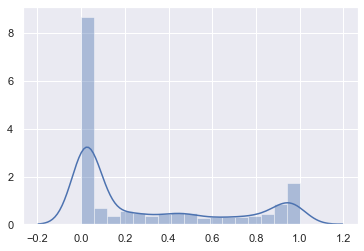

In [609]:
 sns.distplot(y_data)

In [610]:
x_dataset = np.expand_dims(x_data, axis=2)
n_depth = x_dataset.shape[1]
n_width = x_dataset.shape[2]
x_dataset.shape

(6766, 28, 1)

In [611]:
y_dataset = y_data.reshape(y_data.shape[0])
n_targets = y_data.shape[1]
y_dataset.shape

(6766,)

In [612]:

print('Experiment has {} number of features and {} number of target(s)'.format(n_depth,n_targets))


Experiment has 28 number of features and 1 number of target(s)


In [613]:
validate_split = 0.1
test_split = 0.1
train_split = 1 - (test_split + validate_split)

num_data = len(x_dataset)

num_test = int(test_split * num_data)
num_validate = int(validate_split * num_data)
num_train = num_data - (num_test + num_validate)
print('Data splitted to training {} , validation {} and testing {}'.format(num_train, num_validate, num_test))

Data splitted to training 5414 , validation 676 and testing 676


In [614]:
x_train = x_dataset[:num_train]
x_validate = x_dataset[num_train:num_train+num_validate]
x_test = x_dataset[num_train+num_validate:]

print("x_train {} , x_validate {} , x_test {}".format(x_train.shape, x_validate.shape, x_test.shape))

len(x_train) + len(x_validate) + len(x_test)

x_train (5414, 28, 1) , x_validate (676, 28, 1) , x_test (676, 28, 1)


6766

In [615]:
y_train = y_dataset[:num_train]
y_validate = y_dataset[num_train:num_train+num_validate]
y_test = y_dataset[num_train+num_validate:]

print("y_train {} , y_validate {} , y_test {}".format(y_train.shape, y_validate.shape, y_test.shape))

len(y_train) + len(y_validate) + len(y_test)

y_train (5414,) , y_validate (676,) , y_test (676,)


6766

# Scaling Features

In [616]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

if SCALE_FEATURES:
    x_scaler = StandardScaler()  # StandardScaler() or MinMaxScaler()
    
    dim_z, dim_x, dim_y = x_train.shape[0], x_train.shape[1], x_train.shape[2]
    x_train = x_train.reshape(dim_z, dim_x)    
    x_train = x_scaler.fit_transform(x_train)
    x_train = x_train.reshape(dim_z, dim_x, dim_y)
    
    dim_z, dim_x, dim_y = x_test.shape[0], x_test.shape[1], x_test.shape[2]
    x_test = x_test.reshape(dim_z, dim_x)    
    x_test = x_scaler.transform(x_test)
    x_test = x_test.reshape(dim_z, dim_x, dim_y)

In [617]:
print('y_test shape {}'.format(y_test.shape))
y_test[0:10]

y_test shape (676,)


array([0.39943049, 0.9290853 , 0.03905447, 0.31352333, 0.01438849,
       0.49948613, 0.09249743, 0.94655704, 0.12088306, 0.86330935])

In [618]:
# data batch generator
def batch_generator(batch_size, sequence_length=n_depth, n_features=n_width):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, n_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        #y_shape = (batch_size, sequence_length, num_y_signals)
        #y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        y_batch = []

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[idx]
            y_batch.append(y_train[idx])
        
        yield (x_batch, np.array(y_batch))

In [619]:
generator = batch_generator(batch_size)

In [620]:
# test the batch generator
if 1 == 0:
    x_batch, y_batch = next(generator)
    print(x_batch.shape)
    print(y_batch.shape)

In [621]:
# test and validate tuples
test_data = (x_test, y_test)
validate_data = (x_validate, y_validate)

# Model

In [622]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import RMSprop, Adam
from keras import models
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [623]:
# 1-D CONV CNN for feature recognition
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, kernel_initializer='normal', activation='relu', input_shape=(n_depth,n_width)))
model.add(Conv1D(filters=64, kernel_size=5, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(n_targets, kernel_initializer='normal', activation='linear'))

adam = Adam(lr=learning_rate, decay=decay)
# or loss= 'mean_absolute_percentage_error'
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 24, 64)            384       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 20, 64)            20544     
_________________________________________________________________
dropout_19 (Dropout)         (None, 20, 64)            0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 200)               128200    
_________________________________________________________________
dense_74 (Dense)             (None, 100)               20100     
__________

In [624]:
# call backs
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

# save the best model only
path_model = models_dir + 'best_mlp_model.h5'
mc = ModelCheckpoint(path_model
                     , monitor='val_loss'
                     , mode='min' 
                     , verbose=1
                     #, save_weights_only=True
                     , save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [es, mc, reduce_lr]

In [625]:
%%time
steps_per_epoch = math.ceil(num_train / batch_size)   # = total number of training data points divided by the batch size
print('steps_per_epoch {}'.format(steps_per_epoch))

if RUN_MODEL:
    history = model.fit_generator(generator=generator, epochs=epochs
                                  , steps_per_epoch=steps_per_epoch
                                  , validation_data=validate_data
                                  , callbacks=callbacks, verbose=1, shuffle=False)
    #history = model.fit(x_train, y_train, epochs=epochs
                        #, verbose=1,callbacks=callbacks,shuffle=True,validation_data=validate_data)
    
    

steps_per_epoch 19
Epoch 1/2000
19/19 [==============================] - 6s 330ms/step - loss: 0.1486 - mean_squared_error: 0.1486 - val_loss: 1457.6164 - val_mean_squared_error: 1457.6164

Epoch 00001: val_loss improved from inf to 1457.61636, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 2/2000
19/19 [==============================] - 1s 44ms/step - loss: 0.0999 - mean_squared_error: 0.0999 - val_loss: 1238.8481 - val_mean_squared_error: 1238.8481

Epoch 00002: val_loss improved from 1457.61636 to 1238.84809, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 3/2000
19/19 [==============================] - 1s 44ms/step - loss: 0.0851 - mean_squared_error: 0.0851 - val_loss: 137.0593 - val_mean_squared_error: 137.0593

Epoch 00003: val_loss improved from 1238.84809 to 137.05930, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.


Epoch 00035: val_loss did not improve from 0.20685
Epoch 36/2000
19/19 [==============================] - 1s 50ms/step - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 2.5741 - val_mean_squared_error: 2.5741

Epoch 00036: val_loss did not improve from 0.20685
Epoch 37/2000
19/19 [==============================] - 1s 50ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 3.2284 - val_mean_squared_error: 3.2284

Epoch 00037: val_loss did not improve from 0.20685
Epoch 38/2000
19/19 [==============================] - 1s 52ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 4.4651 - val_mean_squared_error: 4.4651

Epoch 00038: val_loss did not improve from 0.20685
Epoch 39/2000
19/19 [==============================] - 1s 52ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 5.1433 - val_mean_squared_error: 5.1433

Epoch 00039: val_loss did not improve from 0.20685
Epoch 40/2000
19/19 [==============================] - 1s 51ms/step - loss: 0.0332 -

19/19 [==============================] - 1s 53ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 170.4302 - val_mean_squared_error: 170.4302

Epoch 00073: val_loss did not improve from 0.20685
Epoch 74/2000
19/19 [==============================] - 1s 53ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 124.9161 - val_mean_squared_error: 124.9161

Epoch 00074: val_loss did not improve from 0.20685
Epoch 75/2000
19/19 [==============================] - 1s 50ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 248.2383 - val_mean_squared_error: 248.2383

Epoch 00075: val_loss did not improve from 0.20685
Epoch 76/2000
19/19 [==============================] - 1s 50ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 129.5559 - val_mean_squared_error: 129.5559

Epoch 00076: val_loss did not improve from 0.20685
Epoch 77/2000
19/19 [==============================] - 1s 52ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 171.0468 -

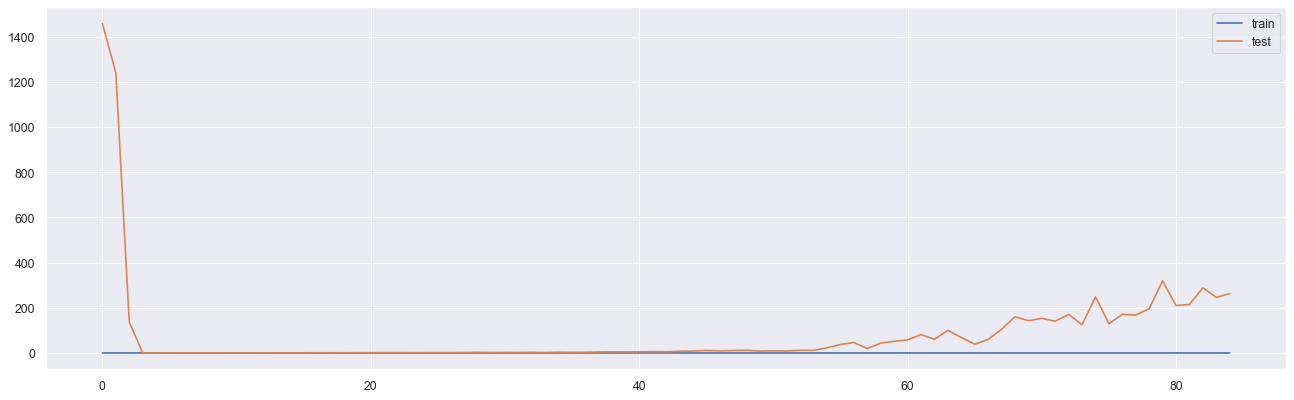

In [626]:
# plot history
if RUN_MODEL:
    plt.figure(figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [627]:
val_loss = history.history['val_loss']
val_loss_df = pd.DataFrame(val_loss)

print("Model Validation MSE mean: %.2f  std: (%.2f)" % \
      (val_loss_df.mean(), val_loss_df.std()))


Model Validation MSE mean: 84.23  std: (213.89)


In [628]:
# Load the best saved model
try:
    model = models.load_model(path_model)
except Exception as error:
    print("Error trying to load model.")
    print(error)
    

# Plot Prediction

In [629]:
def y_comparison(start_idx, length=100, target_scaled=False, data_set='train'):
    """
    Obtain predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if data_set == 'train':
        # Use training-data.
        x = x_train
        y_true = y_train
    elif data_set == 'validate':
        x = x_validate
        y_true = y_validate
    else:
        # Use test-data.
        x = x_test
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    #x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    y_true = y_true.reshape(y_true.shape[0], 1)
    
    #if target_scaled:
        # The output of the model is scaled.
        # Do an inverse map to get it back to the scale
        # of the original data-set.
        #y_true = y_scaler.inverse_transform(y_true)
        #y_pred = y_scaler.inverse_transform(y_pred)
       
    y_true = y_true.reshape(y_true.shape[0])
    y_pred = y_pred.reshape(y_pred.shape[0])
    
    print("shape y_pred: %", y_pred.shape)
    print("shape y_true: %", y_true.shape)
    
    return y_true, y_pred


#This helper-function plots the predicted and true output-signals.
def plot_comparison(signal_true, signal_pred):
    """
    Plot the predicted and true output-signals.
    """

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
        
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
        
    # Plot grey box for warmup-period.
    #p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
    # Plot labels etc.
    plt.ylabel('ltcy')
    plt.legend()
    plt.show()

# Check on Some Training Data

Let us start with an example from the training-data. This is data that the model has seen during training so it should perform reasonably well on this data.

In [630]:
print("total number of training targets {}".format(num_train))
train_true, train_pred = y_comparison(start_idx=0, length=num_train, data_set='train')

stack = np.stack((train_true[0:10], train_pred[0:10]), axis=-1)
stack

total number of training targets 5414
shape y_pred: % (5414,)
shape y_true: % (5414,)


array([[0.95991778, 0.74194521],
       [0.07810894, 0.11771043],
       [0.39362795, 0.03836953],
       [0.02158273, 0.03270134],
       [0.29496403, 0.09015241],
       [0.02261048, 0.03322835],
       [0.02261048, 0.02137831],
       [0.24768756, 0.20569587],
       [0.00822199, 0.04831507],
       [0.02261048, 0.02013911]])

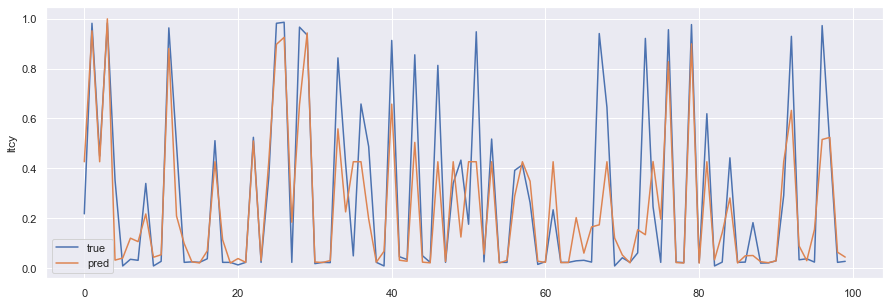

In [631]:
plot_comparison(train_true[10:110], train_pred[10:110])

In [632]:
# calculate RMSE
mse = math.sqrt(mean_squared_error(train_true, train_pred))
print('Train MSE: %.3f' % mse)

Train MSE: 0.206


<function matplotlib.pyplot.show(*args, **kw)>

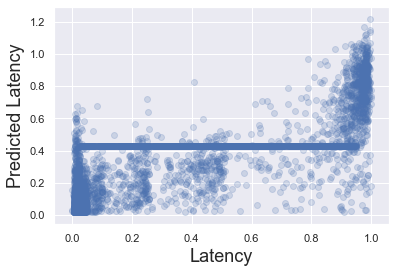

In [633]:
plt.scatter(train_true, train_pred, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

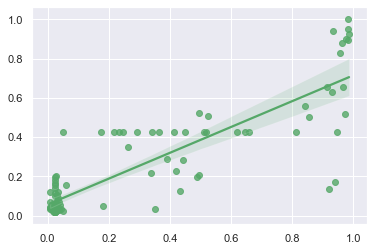

In [634]:
ax = sns.regplot(x=train_true[10:110], y=train_pred[10:110], color='g')

In [635]:
r2_train = metrics.r2_score(train_true, train_pred)
print('R2 (training) = {}'.format(r2_train))

R2 (training) = 0.6773564813833005


# Evaluate Model

In [636]:
print("total number of testing targets {}".format(num_test))
test_true, test_pred = y_comparison(start_idx=0, length=num_test, data_set='test')


stack = np.stack((test_true[0:10], test_pred[0:10]), axis=-1)
stack


total number of testing targets 676
shape y_pred: % (676,)
shape y_true: % (676,)


array([[0.39943049, 0.42617589],
       [0.9290853 , 0.84405017],
       [0.03905447, 0.08579025],
       [0.31352333, 0.42617589],
       [0.01438849, 0.07284229],
       [0.49948613, 0.2880947 ],
       [0.09249743, 0.25789636],
       [0.94655704, 0.73525125],
       [0.12088306, 0.42617589],
       [0.86330935, 0.46902603]])

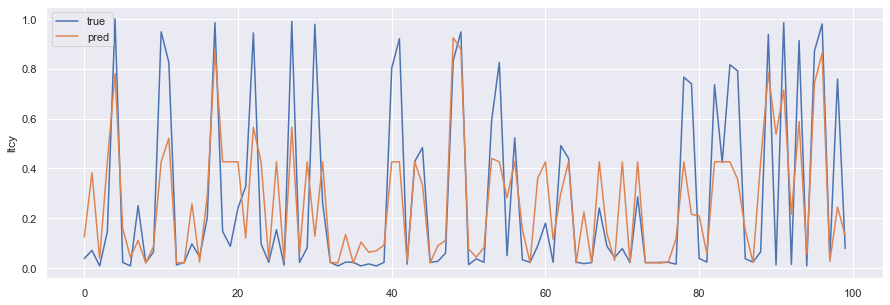

In [637]:
plot_comparison(test_true[10:110], test_pred[10:110])

Text(0.5, 1.0, 'Residual PDF')

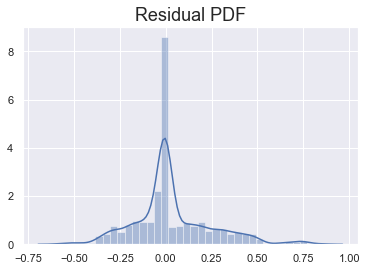

In [638]:
sns.distplot(test_true - test_pred)
plt.title('Residual PDF', size=18)

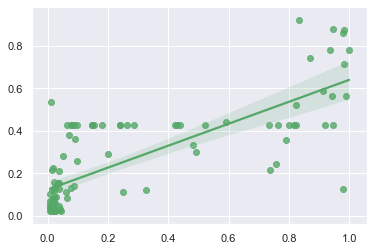

In [639]:
ax = sns.regplot(x=test_true[10:110], y=test_pred[10:110], color='g')

<function matplotlib.pyplot.show(*args, **kw)>

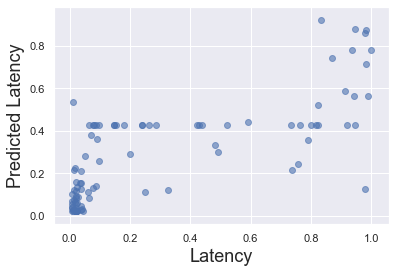

In [640]:
plt.scatter(test_true[10:110], test_pred[10:110], alpha=0.6)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [641]:
print('shape y test {}'.format(test_true.shape))
print('shape y predicted {}'.format(test_pred.shape))

#print ("Actual test values: \n {}".format(test_signal_true[:20]))
#print ("Predicted test values: \n {}".format(test_signal_pred[:20]))

print("")
# calculate RMSE
mse = math.sqrt(mean_squared_error(test_true, test_pred))
print('Test MSE: %.3f' % mse)

shape y test (676,)
shape y predicted (676,)

Test MSE: 0.216


In [642]:
true_df = round(pd.DataFrame(test_true, columns=['actual']),2)
pred_df = round(pd.DataFrame(test_pred, columns=['predicted']),2)


compare_df = pd.concat([true_df,pred_df], axis=1, sort=False)

# testing mean_absolute_percentage_error
compare_df['residual'] = round(compare_df['actual'] - compare_df['predicted'], 2)
compare_df['difference%'] = round(np.absolute(compare_df['residual']* 100 / compare_df['actual']),2)

compare_df.head(5)

,actual,predicted,residual,difference%
0,0.4000,0.4300,-0.0300,7.5000
1,0.9300,0.8400,0.0900,9.6800
2,0.0400,0.0900,-0.0500,125.0000
3,0.3100,0.4300,-0.1200,38.7100
4,0.0100,0.0700,-0.0600,600.0000


In [643]:
compare_df.describe()

,actual,predicted,residual,difference%
count,676.0000,676.0000,676.0000,676.0000
mean,0.2926,0.2600,0.0325,202.2014
std,0.3516,0.2517,0.2142,539.8732
min,0.0100,0.0200,-0.5800,0.0000
25%,0.0200,0.0300,-0.0600,9.5800
50%,0.0600,0.2000,0.0000,43.7500
75%,0.5325,0.4300,0.1200,107.3200
max,1.0000,1.1300,0.8500,"5,300.0000"


In [644]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.4f' % x)
compare_df.sort_values(by = ['difference%'])

,actual,predicted,residual,difference%
337,0.0200,0.0200,0.0000,0.0000
346,0.0200,0.0200,0.0000,0.0000
335,0.0200,0.0200,0.0000,0.0000
330,0.0200,0.0200,0.0000,0.0000
329,0.0200,0.0200,0.0000,0.0000
326,0.0200,0.0200,0.0000,0.0000
319,0.0200,0.0200,0.0000,0.0000
309,0.0200,0.0200,0.0000,0.0000
306,0.0200,0.0200,0.0000,0.0000
305,0.9400,0.9400,0.0000,0.0000


In [645]:
print("... FINISH ....")

... FINISH ....


# *** R2

In [646]:
r2_test = metrics.r2_score(test_true, test_pred)
print('R2 (testing) = {}'.format(r2_test))

R2 (testing) = 0.6195525372469042
